# signals

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional

## accessors

In [3]:
index = pd.Index([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
])
columns = ['a', 'b', 'c']
big_index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]

In [4]:
entries = pd.DataFrame({
    'a': [True, False, False, False, False],
    'b': [True, False, True, False, True],
    'c': [True, True, True, False, False],
}, index=index)
print(entries.shape)

big_entries = pd.DataFrame(np.full((1000, 1000), False), index=big_index)
big_entries.iloc[::10] = True
print(big_entries.shape)

(5, 3)
(1000, 1000)


In [5]:
ts = pd.Series([1., 2., 3., 2., 1.], index=index, name=columns[0])
print(ts.shape)

big_ts = pd.Series(np.random.uniform(10, 13, size=(1000,)), index=big_index)
print(big_ts.shape)

(5,)
(1000,)


In [6]:
price = pd.DataFrame({
    'open': [10, 11, 12, 11, 10],
    'high': [11, 12, 13, 12, 11],
    'low': [9, 10, 11, 10, 9],
    'close': [10, 11, 12, 11, 10]
})

In [7]:
a = np.random.randint(-1, 2, size=(5, 3))
print(a.shape)

big_a = np.random.randint(-1, 2, size=(1000, 1000))
print(big_a.shape)

(5, 3)
(1000, 1000)


In [8]:
print(pd.Series.vbt.signals.empty(5, index=index))
print(pd.DataFrame.vbt.signals.empty((5, 3), index=index, columns=columns))

%timeit pd.DataFrame.vbt.signals.empty((1000, 1000))

2018-01-01    False
2018-01-02    False
2018-01-03    False
2018-01-04    False
2018-01-05    False
dtype: bool
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05  False  False  False
115 µs ± 7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
@njit
def choice_func_nb(from_i, to_i, col):
    return np.random.choice(np.arange(from_i, to_i), size=1, replace=False)

print(pd.Series.vbt.signals.generate(5, choice_func_nb, index=index))
print(pd.DataFrame.vbt.signals.generate((5, 3), choice_func_nb, index=index, columns=columns))

%timeit pd.DataFrame.vbt.signals.generate((1000, 1000), choice_func_nb)

2018-01-01    False
2018-01-02    False
2018-01-03    False
2018-01-04     True
2018-01-05    False
dtype: bool
                a      b      c
2018-01-01  False  False  False
2018-01-02  False   True  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05   True  False   True
15.5 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
@njit
def entry_func_nb(from_i, to_i, col, temp_int):
    temp_int[0] = from_i
    return temp_int[:1]

@njit
def exit_func_nb(from_i, to_i, col, temp_int):
    temp_int[0] = from_i
    return temp_int[:1]

temp_int = np.empty((1000,), dtype=np.int_)
en, ex = pd.Series.vbt.signals.generate_both(
    a.shape[0], entry_func_nb, exit_func_nb, entry_args=(temp_int,), exit_args=(temp_int,), 
    index=index)
print(en)
print(ex)
en, ex = pd.DataFrame.vbt.signals.generate_both(
    a.shape, entry_func_nb, exit_func_nb, entry_args=(temp_int,), exit_args=(temp_int,), 
    index=index, columns=columns)
print(en)
print(ex)
en, ex = pd.DataFrame.vbt.signals.generate_both(
    a.shape, entry_func_nb, exit_func_nb, entry_args=(temp_int,), exit_args=(temp_int,), 
    index=index, columns=columns, entry_wait=1, exit_wait=0)
print(en)
print(ex)
en, ex = pd.DataFrame.vbt.signals.generate_both(
    a.shape, entry_func_nb, exit_func_nb, entry_args=(temp_int,), exit_args=(temp_int,), 
    index=index, columns=columns, entry_wait=0, exit_wait=1)
print(en)
print(ex)

%timeit pd.DataFrame.vbt.signals.generate_both(\
    big_a.shape, entry_func_nb, exit_func_nb, entry_args=(temp_int,), exit_args=(temp_int,))

2018-01-01     True
2018-01-02    False
2018-01-03     True
2018-01-04    False
2018-01-05     True
dtype: bool
2018-01-01    False
2018-01-02     True
2018-01-03    False
2018-01-04     True
2018-01-05    False
dtype: bool
                a      b      c
2018-01-01   True   True   True
2018-01-02  False  False  False
2018-01-03   True   True   True
2018-01-04  False  False  False
2018-01-05   True   True   True
                a      b      c
2018-01-01  False  False  False
2018-01-02   True   True   True
2018-01-03  False  False  False
2018-01-04   True   True   True
2018-01-05  False  False  False
               a     b     c
2018-01-01  True  True  True
2018-01-02  True  True  True
2018-01-03  True  True  True
2018-01-04  True  True  True
2018-01-05  True  True  True
               a     b     c
2018-01-01  True  True  True
2018-01-02  True  True  True
2018-01-03  True  True  True
2018-01-04  True  True  True
2018-01-05  True  True  True
               a     b     c
2018-01-01  Tru

In [12]:
@njit
def choice_func_nb(from_i, to_i, col, temp_int):
    temp_int[0] = from_i
    return temp_int[:1]

print(entries.vbt.signals.generate_exits(choice_func_nb, temp_int))
print(entries.vbt.signals.generate_exits(choice_func_nb, temp_int, wait=0))

%timeit big_entries.vbt.signals.generate_exits(choice_func_nb, temp_int)

                a      b      c
2018-01-01  False  False  False
2018-01-02   True   True  False
2018-01-03  False  False  False
2018-01-04  False   True   True
2018-01-05  False  False  False
                a      b      c
2018-01-01   True   True   True
2018-01-02  False  False   True
2018-01-03  False   True   True
2018-01-04  False  False  False
2018-01-05  False   True  False
38 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
print(pd.Series.vbt.signals.generate_random(5, n=2, seed=42, index=index))
print(pd.DataFrame.vbt.signals.generate_random((5, 3), n=2, seed=42, index=index, columns=columns))
print(pd.DataFrame.vbt.signals.generate_random((5, 3), n=[0, 1, 2], seed=42, index=index, columns=columns))

%timeit pd.DataFrame.vbt.signals.generate_random((1000, 1000), n=100)

2018-01-01    False
2018-01-02     True
2018-01-03    False
2018-01-04    False
2018-01-05     True
dtype: bool
                a      b      c
2018-01-01  False  False   True
2018-01-02   True   True   True
2018-01-03  False  False  False
2018-01-04  False   True  False
2018-01-05   True  False  False
                a      b      c
2018-01-01  False  False   True
2018-01-02  False  False   True
2018-01-03  False  False  False
2018-01-04  False   True  False
2018-01-05  False  False  False
14.7 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
print(pd.Series.vbt.signals.generate_random(5, prob=0.5, seed=42, index=index))
print(pd.DataFrame.vbt.signals.generate_random((5, 3), prob=0.5, seed=42, index=index, columns=columns))
print(pd.DataFrame.vbt.signals.generate_random((5, 3), prob=[0., 0.5, 1], seed=42, index=index, columns=columns))

%timeit pd.DataFrame.vbt.signals.generate_random((1000, 1000), prob=0.5)

2018-01-01     True
2018-01-02    False
2018-01-03    False
2018-01-04    False
2018-01-05     True
dtype: bool
                a      b      c
2018-01-01   True   True   True
2018-01-02  False   True  False
2018-01-03  False  False  False
2018-01-04  False  False   True
2018-01-05   True  False   True
                a      b     c
2018-01-01  False   True  True
2018-01-02  False   True  True
2018-01-03  False  False  True
2018-01-04  False  False  True
2018-01-05  False  False  True
19.5 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
print(entries['a'].vbt.signals.generate_random_exits(seed=42))
print(entries.vbt.signals.generate_random_exits(seed=42))
print(entries.vbt.signals.generate_random_exits(seed=42, wait=0))

%timeit big_entries.vbt.signals.generate_random_exits(seed=42)

2018-01-01    False
2018-01-02    False
2018-01-03     True
2018-01-04    False
2018-01-05    False
Name: a, dtype: bool
                a      b      c
2018-01-01  False  False  False
2018-01-02  False   True  False
2018-01-03   True  False  False
2018-01-04  False   True  False
2018-01-05  False  False   True
                a      b      c
2018-01-01  False   True   True
2018-01-02   True  False   True
2018-01-03  False  False  False
2018-01-04  False   True   True
2018-01-05  False   True  False
116 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
print(entries['a'].vbt.signals.generate_random_exits(prob=1., seed=42))
print(entries.vbt.signals.generate_random_exits(prob=1., seed=42))
print(entries.vbt.signals.generate_random_exits(prob=[0., 0.5, 1], seed=42))
print(entries.vbt.signals.generate_random_exits(prob=1., seed=42, wait=0))

%timeit big_entries.vbt.signals.generate_random_exits(prob=1., seed=42)

2018-01-01    False
2018-01-02     True
2018-01-03    False
2018-01-04    False
2018-01-05    False
Name: a, dtype: bool
                a      b      c
2018-01-01  False  False  False
2018-01-02   True   True  False
2018-01-03  False  False  False
2018-01-04  False   True   True
2018-01-05  False  False  False
                a      b      c
2018-01-01  False  False  False
2018-01-02  False   True  False
2018-01-03  False  False  False
2018-01-04  False   True   True
2018-01-05  False  False  False
                a      b      c
2018-01-01   True   True   True
2018-01-02  False  False   True
2018-01-03  False   True   True
2018-01-04  False  False  False
2018-01-05  False   True  False
48.8 ms ± 2.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
en, ex = pd.Series.vbt.signals.generate_random_both(5, n=2, seed=42, index=index)
print(en)
print(ex)
en, ex = pd.DataFrame.vbt.signals.generate_random_both((5, 3), n=2, seed=42, index=index, columns=columns)
print(en)
print(ex)
en, ex = pd.DataFrame.vbt.signals.generate_random_both((5, 3), n=[0, 1, 2], seed=42, index=index, columns=columns)
print(en)
print(ex)
en, ex = pd.DataFrame.vbt.signals.generate_random_both((2, 3), n=2, seed=42, entry_wait=1, exit_wait=0)
print(en)
print(ex)
en, ex = pd.DataFrame.vbt.signals.generate_random_both((3, 3), n=2, seed=42, entry_wait=0, exit_wait=1)
print(en)
print(ex)
en, ex = pd.DataFrame.vbt.signals.generate_random_both((7, 3), n=2, seed=42, entry_wait=2, exit_wait=2)
print(en)
print(ex)

%timeit pd.DataFrame.vbt.signals.generate_random_both((1000, 1000), n=100)
%timeit pd.DataFrame.vbt.signals.generate_random_both((1000, 1000), n=100, exit_wait=0)

2018-01-01     True
2018-01-02    False
2018-01-03     True
2018-01-04    False
2018-01-05    False
dtype: bool
2018-01-01    False
2018-01-02     True
2018-01-03    False
2018-01-04    False
2018-01-05     True
dtype: bool
                a      b      c
2018-01-01   True   True   True
2018-01-02  False  False  False
2018-01-03   True   True  False
2018-01-04  False  False   True
2018-01-05  False  False  False
                a      b      c
2018-01-01  False  False  False
2018-01-02   True   True   True
2018-01-03  False  False  False
2018-01-04  False   True  False
2018-01-05   True  False   True
                a      b      c
2018-01-01  False  False   True
2018-01-02  False   True  False
2018-01-03  False  False  False
2018-01-04  False  False   True
2018-01-05  False  False  False
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False   True
2018-01-03  False  False  False
2018-01-04  False   True  False
2018-01-05  False  False   True
      0 

In [18]:
n = 10
a = np.full(n * 2, 0.)
for i in range(10000):
    en, ex = pd.Series.vbt.signals.generate_random_both(1000, n, entry_wait=2, exit_wait=2)
    _a = np.empty((n * 2,), dtype=np.int_)
    _a[0::2] = np.flatnonzero(en)
    _a[1::2] = np.flatnonzero(ex)
    a += _a
print(a)

b = np.full(n * 2, 0.)
for i in range(10000):
    b += np.sort(np.random.choice(1000, size=n * 2, replace=False))
print(b)

[ 454915.  931362. 1423666. 1894465. 2368430. 2859191. 3338920. 3817177.
 4288740. 4759056. 5236445. 5708131. 6183311. 6675387. 7160407. 7633895.
 8117773. 8596158. 9073611. 9541106.]
[ 463784.  939322. 1417342. 1891760. 2374673. 2847826. 3320464. 3798530.
 4275863. 4753034. 5228158. 5707274. 6190433. 6664680. 7142259. 7618979.
 8094704. 8571274. 9044004. 9526862.]


In [19]:
en, ex = pd.Series.vbt.signals.generate_random_both(
    5, entry_prob=0.5, exit_prob=1., seed=42, index=index)
print(en)
print(ex)
en, ex = pd.DataFrame.vbt.signals.generate_random_both(
    (5, 3), entry_prob=0.5, exit_prob=1., seed=42, index=index, columns=columns)
print(en)
print(ex)
en, ex = pd.DataFrame.vbt.signals.generate_random_both(
    (5, 3), entry_prob=[0., 0.5, 1.], exit_prob=[0., 0.5, 1.], seed=42, index=index, columns=columns)
print(en)
print(ex)
en, ex = pd.DataFrame.vbt.signals.generate_random_both(
    (5, 3), entry_prob=1., exit_prob=1., seed=42, index=index, columns=columns, exit_wait=0)
print(en)
print(ex)

%timeit pd.DataFrame.vbt.signals.generate_random_both(\
    (1000, 1000), entry_prob=1., exit_prob=1.)

2018-01-01     True
2018-01-02    False
2018-01-03    False
2018-01-04    False
2018-01-05     True
dtype: bool
2018-01-01    False
2018-01-02     True
2018-01-03    False
2018-01-04    False
2018-01-05    False
dtype: bool
                a      b      c
2018-01-01   True   True   True
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False   True
2018-01-05   True  False  False
                a      b      c
2018-01-01  False  False  False
2018-01-02   True   True   True
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05  False  False   True
                a      b      c
2018-01-01  False   True   True
2018-01-02  False  False  False
2018-01-03  False  False   True
2018-01-04  False  False  False
2018-01-05  False  False   True
                a      b      c
2018-01-01  False  False  False
2018-01-02  False   True   True
2018-01-03  False  False  False
2018-01-04  False  False   True
2018-01-05  False  False  False
        

In [20]:
e = pd.Series([True, False, False, False, False, False])
t = pd.Series([2, 3, 4, 3, 2, 1]).astype(np.float64)

print(e.vbt.signals.generate_stop_exits(t, -0.1))
print(e.vbt.signals.generate_stop_exits(t, -0.1, trailing=True))
print(e.vbt.signals.generate_stop_exits(t, -0.1, trailing=True, first=False))
print(e.vbt.signals.generate_stop_exits(t.vbt.tile(3), [-0., -0.5, -1.], trailing=True, first=False))
print(e.vbt.signals.generate_stop_exits(t, -0.1, trailing=True, exit_wait=3))

print(e.vbt.signals.generate_stop_exits(4 - t, 0.1))
print(e.vbt.signals.generate_stop_exits(4 - t, 0.1, trailing=True))
print(e.vbt.signals.generate_stop_exits(4 - t, 0.1, trailing=True, first=False))
print(e.vbt.signals.generate_stop_exits((4 - t).vbt.tile(3), [0., 0.5, 1.], trailing=True, first=False))
print(e.vbt.signals.generate_stop_exits(4 - t, 0.1, trailing=True, exit_wait=3))

%timeit big_entries.vbt.signals.generate_stop_exits(big_ts, -0.1)
%timeit big_entries.vbt.signals.generate_stop_exits(big_ts, -0.1, trailing=True)
%timeit big_entries.vbt.signals.generate_stop_exits(big_ts, -0.1, trailing=True, first=False)

0    False
1    False
2    False
3    False
4    False
5     True
dtype: bool
0    False
1    False
2    False
3     True
4    False
5    False
dtype: bool
0    False
1    False
2    False
3     True
4     True
5     True
dtype: bool
       0      1      2
0  False  False  False
1  False  False  False
2  False  False  False
3  False  False  False
4  False   True  False
5  False   True  False
0    False
1    False
2    False
3    False
4     True
5    False
dtype: bool
0    False
1    False
2    False
3    False
4    False
5     True
dtype: bool
0    False
1    False
2    False
3     True
4    False
5    False
dtype: bool
0    False
1    False
2    False
3     True
4     True
5     True
dtype: bool
       0      1      2
0  False  False  False
1  False  False  False
2  False  False  False
3  False   True   True
4  False   True   True
5  False   True   True
0    False
1    False
2    False
3    False
4     True
5    False
dtype: bool
62.3 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs

In [21]:
e = pd.Series([True, True, True, True, True, True])
t = pd.Series([2, 3, 4, 3, 2, 1]).astype(np.float64)

en, ex = e.vbt.signals.generate_stop_exits(t, -0.1, trailing=True, iteratively=True)
print(en)
print(ex)
en, ex = e.vbt.signals.generate_stop_exits(t, -0.1, trailing=True, entry_wait=2, iteratively=True)
print(en)
print(ex)
en, ex = e.vbt.signals.generate_stop_exits(t, -0.1, trailing=True, exit_wait=2, iteratively=True)
print(en)
print(ex)

%timeit big_entries.vbt.signals.generate_stop_exits(big_ts, -0.1, iteratively=True)
%timeit big_entries.vbt.signals.generate_stop_exits(big_ts, -0.1, trailing=True, iteratively=True)
%timeit big_entries.vbt.signals.generate_stop_exits(big_ts, -0.1, trailing=True, first=False, iteratively=True)

0     True
1    False
2    False
3    False
4     True
5    False
dtype: bool
0    False
1    False
2    False
3     True
4    False
5     True
dtype: bool
0     True
1    False
2    False
3    False
4    False
5     True
dtype: bool
0    False
1    False
2    False
3     True
4    False
5    False
dtype: bool
0     True
1    False
2    False
3    False
4     True
5    False
dtype: bool
0    False
1    False
2    False
3     True
4    False
5    False
dtype: bool
9.03 ms ± 551 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
52 ms ± 512 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
52 ms ± 878 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
def test_adv_stop_exits(**kwargs):
    out_dict = {}
    result = entries.vbt.signals.generate_adv_stop_exits(
        price['open'], price['high'], price['low'], price['close'],
        out_dict=out_dict, **kwargs
    )
    if isinstance(result, tuple):
        _, ex = result
    else:
        ex = result
    out_dict['hit_price'][~ex] = np.nan
    out_dict['stop_type'][~ex] = -1
    return result, out_dict['hit_price'], out_dict['stop_type']

ex, hit_price, stop_type = test_adv_stop_exits()
print(ex)
print(hit_price)
print(stop_type)

ex, hit_price, stop_type = test_adv_stop_exits(sl_stop=0.1)
print(ex)
print(hit_price)
print(stop_type)

ex, hit_price, stop_type = test_adv_stop_exits(ts_stop=0.1)
print(ex)
print(hit_price)
print(stop_type)

ex, hit_price, stop_type = test_adv_stop_exits(tp_stop=0.1)
print(ex)
print(hit_price)
print(stop_type)

ex, hit_price, stop_type = test_adv_stop_exits(sl_stop=0.1, ts_stop=0.1, tp_stop=0.1)
print(ex)
print(hit_price)
print(stop_type)

ex, hit_price, stop_type = test_adv_stop_exits(sl_stop=[0., 0.5, 1.], ts_stop=[0., 0.5, 1.], tp_stop=[0., 0.5, 1.])
print(ex)
print(hit_price)
print(stop_type)

ex, hit_price, stop_type = test_adv_stop_exits(sl_stop=0.1, ts_stop=0.1, tp_stop=0.1, exit_wait=0)
print(ex)
print(hit_price)
print(stop_type)

%timeit big_entries.vbt.signals.generate_adv_stop_exits(\
    big_ts, big_ts + 1, big_ts - 1, big_ts, sl_stop=0.1, ts_stop=0.1, tp_stop=0.1)

                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05  False  False  False
             a   b   c
2018-01-01 NaN NaN NaN
2018-01-02 NaN NaN NaN
2018-01-03 NaN NaN NaN
2018-01-04 NaN NaN NaN
2018-01-05 NaN NaN NaN
            a  b  c
2018-01-01 -1 -1 -1
2018-01-02 -1 -1 -1
2018-01-03 -1 -1 -1
2018-01-04 -1 -1 -1
2018-01-05 -1 -1 -1
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False   True   True
2018-01-05   True  False  False
              a     b     c
2018-01-01  NaN   NaN   NaN
2018-01-02  NaN   NaN   NaN
2018-01-03  NaN   NaN   NaN
2018-01-04  NaN  10.8  10.8
2018-01-05  9.0   NaN   NaN
            a  b  c
2018-01-01 -1 -1 -1
2018-01-02 -1 -1 -1
2018-01-03 -1 -1 -1
2018-01-04 -1  0  0
2018-01-05  0 -1 -1
                a      b      c
2018-01-01  False  False  False
2018-0

In [23]:
(en, ex), hit_price, stop_type = test_adv_stop_exits(sl_stop=0.1, ts_stop=0.1, tp_stop=0.1, iteratively=True)
print(en)
print(ex)
print(hit_price)
print(stop_type)

%timeit big_entries.vbt.signals.generate_adv_stop_exits(\
    big_ts, big_ts + 1, big_ts - 1, big_ts, sl_stop=0.1, ts_stop=0.1, tp_stop=0.1, iteratively=True)

                a      b      c
2018-01-01   True   True   True
2018-01-02  False  False  False
2018-01-03  False   True   True
2018-01-04  False  False  False
2018-01-05  False   True  False
                a      b      c
2018-01-01  False  False  False
2018-01-02   True   True   True
2018-01-03  False  False  False
2018-01-04  False   True   True
2018-01-05  False  False  False
               a     b     c
2018-01-01   NaN   NaN   NaN
2018-01-02  11.0  11.0  11.0
2018-01-03   NaN   NaN   NaN
2018-01-04   NaN  10.8  10.8
2018-01-05   NaN   NaN   NaN
            a  b  c
2018-01-01 -1 -1 -1
2018-01-02  2  2  2
2018-01-03 -1 -1 -1
2018-01-04 -1  0  0
2018-01-05 -1 -1 -1
70.5 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
distance_map_nb = njit(lambda prev_i, next_i, col: next_i - prev_i)
avg_reduce_nb = njit(lambda col, a: np.nanmean(a))

print(entries.vbt.signals.map_reduce_between(map_func_nb=distance_map_nb, reduce_func_nb=avg_reduce_nb))

%timeit big_entries.vbt.signals.map_reduce_between(map_func_nb=distance_map_nb, reduce_func_nb=avg_reduce_nb)

a    NaN
b    2.0
c    1.0
dtype: float64
2.67 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
print(entries.vbt.signals.map_reduce_between(
    other=entries.vbt.signals.fshift(1), 
    map_func_nb=distance_map_nb, 
    reduce_func_nb=avg_reduce_nb))

%timeit big_entries.vbt.signals.map_reduce_between(\
    other=big_entries.vbt.signals.fshift(1),\
    map_func_nb=distance_map_nb,\
    reduce_func_nb=avg_reduce_nb)

a    1.0
b    1.0
c    1.0
dtype: float64
The slowest run took 5.87 times longer than the fastest. This could mean that an intermediate result is being cached.
119 ms ± 88.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
print(entries.vbt.signals.map_reduce_partitions(map_func_nb=distance_map_nb, reduce_func_nb=avg_reduce_nb))

%timeit big_entries.vbt.signals.map_reduce_partitions(map_func_nb=distance_map_nb, reduce_func_nb=avg_reduce_nb)

a    1.0
b    1.0
c    3.0
dtype: float64
2.62 ms ± 548 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
print(entries['a'].vbt.signals.num_signals())
print(entries.vbt.signals.num_signals())

%timeit big_entries.vbt.signals.num_signals()

1
a    1
b    3
c    3
dtype: int64
1.78 ms ± 700 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
print(entries['a'].vbt.signals.avg_distance())
print(entries.vbt.signals.avg_distance())

%timeit big_entries.vbt.signals.avg_distance()

nan
a    NaN
b    2.0
c    1.0
dtype: float64
2.72 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
print(entries['a'].vbt.signals.avg_distance(to=entries['a'].vbt.signals.fshift(1)))
print(entries.vbt.signals.avg_distance(to=entries.vbt.signals.fshift(1)))

%timeit big_entries.vbt.signals.avg_distance(to=big_entries.vbt.signals.fshift(1))

1.0
a    1.0
b    1.0
c    1.0
dtype: float64
57.4 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
print(entries['a'].vbt.signals.rank())
print(entries.vbt.signals.rank())

print(entries['a'].vbt.signals.rank(after_false=True))
print(entries.vbt.signals.rank(after_false=True))

print(entries['a'].vbt.signals.rank(allow_gaps=True))
print(entries.vbt.signals.rank(allow_gaps=True))

print(entries['a'].vbt.signals.rank(allow_gaps=True, reset_by=~entries['a']))
print(entries.vbt.signals.rank(allow_gaps=True, reset_by=~entries))

%timeit big_entries.vbt.signals.rank()

2018-01-01    1
2018-01-02    0
2018-01-03    0
2018-01-04    0
2018-01-05    0
Name: a, dtype: int64
            a  b  c
2018-01-01  1  1  1
2018-01-02  0  0  2
2018-01-03  0  1  3
2018-01-04  0  0  0
2018-01-05  0  1  0
2018-01-01    0
2018-01-02    0
2018-01-03    0
2018-01-04    0
2018-01-05    0
Name: a, dtype: int64
            a  b  c
2018-01-01  0  0  0
2018-01-02  0  0  0
2018-01-03  0  1  0
2018-01-04  0  0  0
2018-01-05  0  1  0
2018-01-01    1
2018-01-02    0
2018-01-03    0
2018-01-04    0
2018-01-05    0
Name: a, dtype: int64
            a  b  c
2018-01-01  1  1  1
2018-01-02  0  0  2
2018-01-03  0  2  3
2018-01-04  0  0  0
2018-01-05  0  3  0
2018-01-01    1
2018-01-02    0
2018-01-03    0
2018-01-04    0
2018-01-05    0
Name: a, dtype: int64
            a  b  c
2018-01-01  1  1  1
2018-01-02  0  0  2
2018-01-03  0  1  3
2018-01-04  0  0  0
2018-01-05  0  1  0
6.91 ms ± 41 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
print(entries['a'].vbt.signals.rank_partitions())
print(entries.vbt.signals.rank_partitions())

print(entries['a'].vbt.signals.rank_partitions(after_false=True))
print(entries.vbt.signals.rank_partitions(after_false=True))

print(entries['a'].vbt.signals.rank_partitions(reset_by=~entries['a']))
print(entries.vbt.signals.rank_partitions(reset_by=~entries))

%timeit big_entries.vbt.signals.rank_partitions()

2018-01-01    1
2018-01-02    0
2018-01-03    0
2018-01-04    0
2018-01-05    0
Name: a, dtype: int64
            a  b  c
2018-01-01  1  1  1
2018-01-02  0  0  1
2018-01-03  0  2  1
2018-01-04  0  0  0
2018-01-05  0  3  0
2018-01-01    0
2018-01-02    0
2018-01-03    0
2018-01-04    0
2018-01-05    0
Name: a, dtype: int64
            a  b  c
2018-01-01  0  0  0
2018-01-02  0  0  0
2018-01-03  0  1  0
2018-01-04  0  0  0
2018-01-05  0  2  0
2018-01-01    1
2018-01-02    0
2018-01-03    0
2018-01-04    0
2018-01-05    0
Name: a, dtype: int64
            a  b  c
2018-01-01  1  1  1
2018-01-02  0  0  1
2018-01-03  0  1  1
2018-01-04  0  0  0
2018-01-05  0  1  0
7.55 ms ± 366 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
print(entries.vbt.signals.first())

%timeit big_entries.vbt.signals.first()

                a      b      c
2018-01-01   True   True   True
2018-01-02  False  False  False
2018-01-03  False   True  False
2018-01-04  False  False  False
2018-01-05  False   True  False
9.26 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
print(entries & entries)
%timeit big_entries & big_entries

print(entries.vbt.signals.AND(entries))
%timeit big_entries.vbt.signals.AND(big_entries) # a bit slower but does smart broadcasting

                a      b      c
2018-01-01   True   True   True
2018-01-02  False  False   True
2018-01-03  False   True   True
2018-01-04  False  False  False
2018-01-05  False   True  False
568 µs ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
                a      b      c
2018-01-01   True   True   True
2018-01-02  False  False   True
2018-01-03  False   True   True
2018-01-04  False  False  False
2018-01-05  False   True  False
671 µs ± 21.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [34]:
print(entries.vbt.signals.OR(ts > 1, ts > 2, ts > 3)) # you can pass multiple arguments
print(entries.vbt.signals.OR(ts > 1, ts > 2, ts > 3, concat=True, keys=['>1', '>2', '>3']))

                a     b      c
2018-01-01   True  True   True
2018-01-02   True  True   True
2018-01-03   True  True   True
2018-01-04   True  True   True
2018-01-05  False  True  False
               >1                  >2                   >3              
                a     b      c      a      b      c      a      b      c
2018-01-01   True  True   True   True   True   True   True   True   True
2018-01-02   True  True   True  False  False   True  False  False   True
2018-01-03   True  True   True   True   True   True  False   True   True
2018-01-04   True  True   True  False  False  False  False  False  False
2018-01-05  False  True  False  False   True  False  False   True  False


In [35]:
print(entries.vbt.signals.shuffle(seed=42))

%timeit big_entries.vbt.signals.shuffle(seed=42)

                a      b      c
2018-01-01  False  False   True
2018-01-02  False  False   True
2018-01-03  False   True  False
2018-01-04   True   True  False
2018-01-05  False   True   True
15 ms ± 584 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
print(entries.vbt.signals.fshift(2))

%timeit big_entries.vbt.signals.fshift(2)

                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03   True   True   True
2018-01-04  False  False   True
2018-01-05  False   True   True
565 µs ± 26.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


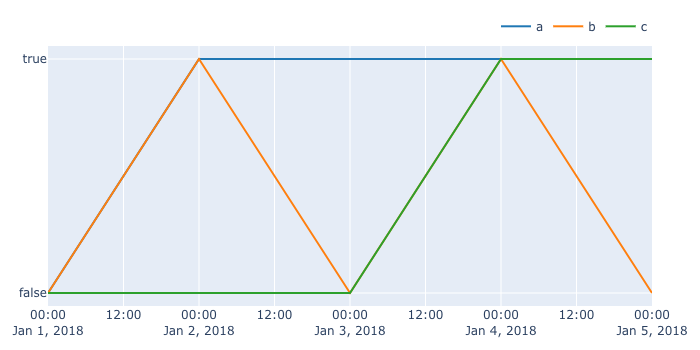

In [37]:
entries.vbt.signals.plot().show_png()

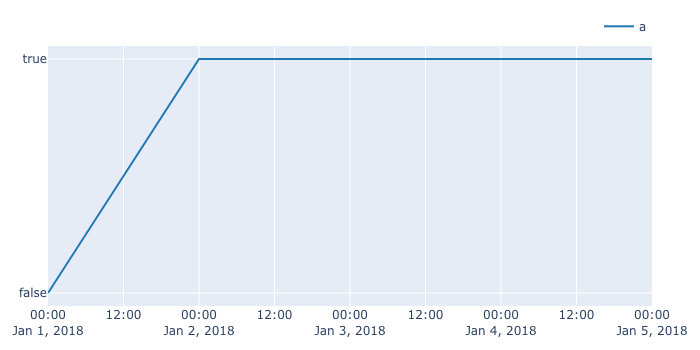

In [38]:
entries['a'].vbt.signals.plot().show_png()

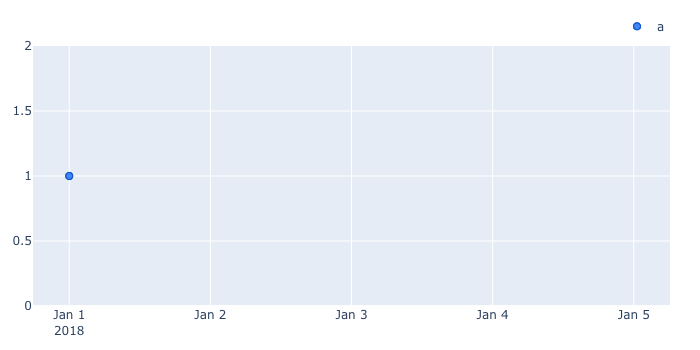

In [39]:
entries['a'].vbt.signals.plot_as_markers(ts).show_png()

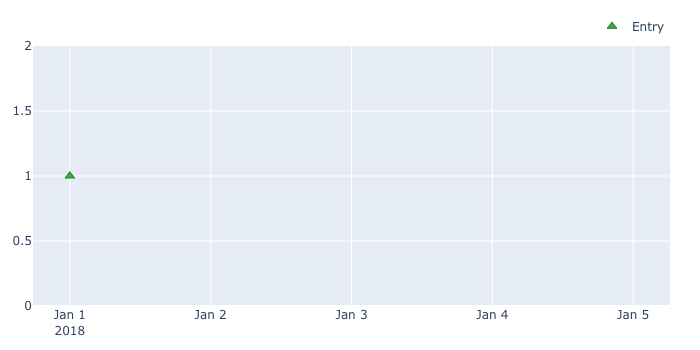

In [40]:
entries['a'].vbt.signals.plot_as_entry_markers(ts).show_png()

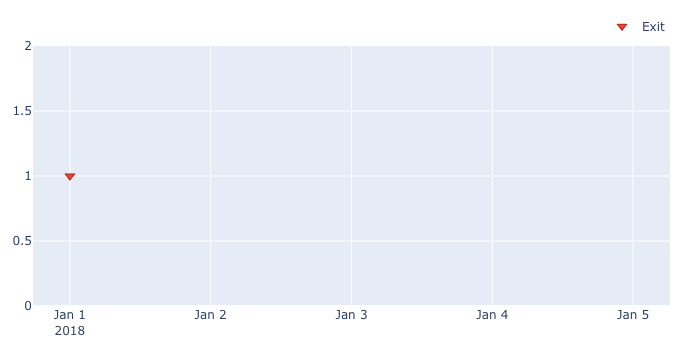

In [41]:
entries['a'].vbt.signals.plot_as_exit_markers(ts).show_png()

## factory

custom_n1      0      1
custom_n2      1      0
0           True   True
1          False  False
2           True   True
3          False  False
4           True   True
custom_n1      0      1
custom_n2      1      0
0          False  False
1           True   True
2          False  False
3           True   True
4          False  False
custom_n1       0       1
custom_n2       1       0
0          1100.0  1100.0
1             NaN     NaN
2          1100.0  1102.0
3             NaN     NaN
4          1100.0  1104.0
custom_n1       0       1
custom_n2       1       0
0             NaN     NaN
1          1101.0  1100.0
2             NaN     NaN
3          1103.0  1100.0
4             NaN     NaN


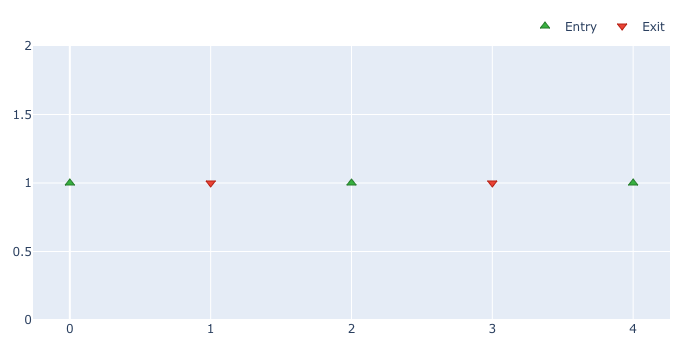

In [38]:
@njit
def choice_nb(from_i, to_i, col, ts, in_out, n, arg, temp_idx_arr, kw):
    in_out[from_i, col] = ts[from_i, col] * n + arg + kw
    temp_idx_arr[0] = from_i
    return temp_idx_arr[:1]

MySignals = vbt.SignalFactory(
    input_names=['ts1', 'ts2'],
    in_output_names=['in_out1', 'in_out2'],
    param_names=['n1', 'n2']
).from_choice_func(
    entry_choice_func=choice_nb,
    entry_settings=dict(
        pass_inputs=['ts1'],
        pass_in_outputs=['in_out1'],
        pass_params=['n1'],
        pass_kwargs=['temp_idx_arr1', ('kw1', 1000)]
    ),
    exit_choice_func=choice_nb,
    exit_settings=dict(
        pass_inputs=['ts2'],
        pass_in_outputs=['in_out2'],
        pass_params=['n2'],
        pass_kwargs=['temp_idx_arr2', ('kw2', 1000)]
    ),
    in_output_settings=dict(
        in_out1=dict(
            dtype=np.float_
        ),
        in_out2=dict(
            dtype=np.float_
        )
    ),
    in_out1=np.nan,
    in_out2=np.nan,
    variable_args=True
)
my_sig = MySignals.run(np.arange(5), np.arange(5), [0, 1], [1, 0], entry_args=(100,), exit_args=(100,))
print(my_sig.entries)
print(my_sig.exits)
print(my_sig.in_out1)
print(my_sig.in_out2)
my_sig[(0, 1)].plot().show_png()

In [9]:
my_sig = MySignals.run(
    np.arange(7), np.arange(7), [0, 1], [1, 0], 
    entry_args=(100,), exit_args=(100,), 
    entry_kwargs=dict(wait=2), exit_kwargs=dict(wait=2)
)
print(my_sig.entries)
print(my_sig.exits)
print(my_sig.in_out1)
print(my_sig.in_out2)

custom_n1      0      1
custom_n2      1      0
0           True   True
1          False  False
2          False  False
3          False  False
4           True   True
5          False  False
6          False  False
custom_n1      0      1
custom_n2      1      0
0          False  False
1          False  False
2           True   True
3          False  False
4          False  False
5          False  False
6           True   True
custom_n1       0       1
custom_n2       1       0
0          1100.0  1100.0
1             NaN     NaN
2             NaN     NaN
3             NaN     NaN
4          1100.0  1104.0
5             NaN     NaN
6             NaN     NaN
custom_n1       0       1
custom_n2       1       0
0             NaN     NaN
1             NaN     NaN
2          1102.0  1100.0
3             NaN     NaN
4             NaN     NaN
5             NaN     NaN
6          1106.0  1100.0


custom_n2      1      0
0           True   True
1          False  False
2           True   True
3          False  False
4           True   True
custom_n2      1      0
0          False  False
1           True   True
2          False  False
3           True   True
4          False  False
custom_n2       1       0
0             NaN     NaN
1          1101.0  1100.0
2             NaN     NaN
3          1103.0  1100.0
4             NaN     NaN


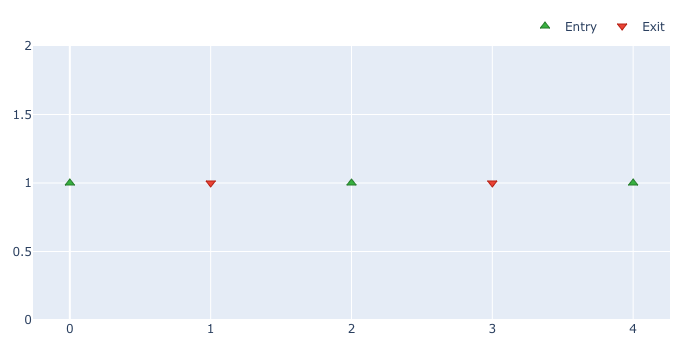

In [11]:
MySignals = vbt.SignalFactory(
    input_names=['ts2'],
    in_output_names=['in_out2'],
    param_names=['n2'],
    exit_only=True
).from_choice_func(
    exit_choice_func=choice_nb,
    exit_settings=dict(
        pass_inputs=['ts2'],
        pass_in_outputs=['in_out2'],
        pass_params=['n2'],
        pass_kwargs=['temp_idx_arr2', ('kw2', 1000)]
    ),
    in_output_settings=dict(
        in_out2=dict(
            dtype=np.float_
        )
    ),
    in_out2=np.nan,
    variable_args=True
)
e = np.array([True, False, True, False, True])
my_sig = MySignals.run(e, np.arange(5), [1, 0], 100)
print(my_sig.entries)
print(my_sig.exits)
print(my_sig.in_out2)
my_sig[0].plot().show_png()

In [12]:
e = np.array([True, False, False, True, False, False])
my_sig = MySignals.run(e, np.arange(6), [1, 0], 100, wait=2)
print(my_sig.entries)
print(my_sig.exits)
print(my_sig.in_out2)

custom_n2      1      0
0           True   True
1          False  False
2          False  False
3           True   True
4          False  False
5          False  False
custom_n2      1      0
0          False  False
1          False  False
2           True   True
3          False  False
4          False  False
5           True   True
custom_n2       1       0
0             NaN     NaN
1             NaN     NaN
2          1102.0  1100.0
3             NaN     NaN
4             NaN     NaN
5          1105.0  1100.0


custom_n2     1     0
0          True  True
1          True  True
2          True  True
3          True  True
4          True  True
custom_n2      1      0
0           True   True
1          False  False
2           True   True
3          False  False
4           True   True
custom_n2      1      0
0          False  False
1           True   True
2          False  False
3           True   True
4          False  False
custom_n2       1       0
0             NaN     NaN
1          1101.0  1100.0
2             NaN     NaN
3          1103.0  1100.0
4             NaN     NaN


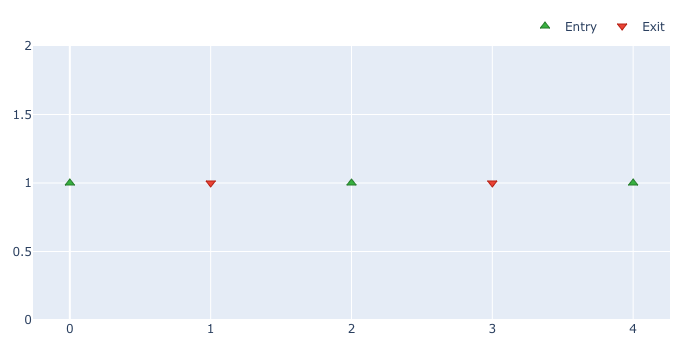

In [13]:
MySignals = vbt.SignalFactory(
    input_names=['ts2'],
    in_output_names=['in_out2'],
    param_names=['n2'],
    iteratively=True
).from_choice_func(
    exit_choice_func=choice_nb,
    exit_settings=dict(
        pass_inputs=['ts2'],
        pass_in_outputs=['in_out2'],
        pass_params=['n2'],
        pass_kwargs=['temp_idx_arr2', ('kw2', 1000)]
    ),
    in_output_settings=dict(
        in_out2=dict(
            dtype=np.float_
        )
    ),
    in_out2=np.nan, 
    variable_args=True
)
e = np.array([True, True, True, True, True])
my_sig = MySignals.run(e, np.arange(5), [1, 0], 100)
print(my_sig.entries)
print(my_sig.new_entries)
print(my_sig.exits)
print(my_sig.in_out2)
my_sig[0].plot().show_png()

In [14]:
e = np.array([True, True, True, True, True, True])
my_sig = MySignals.run(e, np.arange(6), [1, 0], 100, wait=2)
print(my_sig.entries)
print(my_sig.new_entries)
print(my_sig.exits)
print(my_sig.in_out2)

custom_n2     1     0
0          True  True
1          True  True
2          True  True
3          True  True
4          True  True
5          True  True
custom_n2      1      0
0           True   True
1          False  False
2          False  False
3           True   True
4          False  False
5          False  False
custom_n2      1      0
0          False  False
1          False  False
2           True   True
3          False  False
4          False  False
5           True   True
custom_n2       1       0
0             NaN     NaN
1             NaN     NaN
2          1102.0  1100.0
3             NaN     NaN
4             NaN     NaN
5          1105.0  1100.0


## basic

### RAND

In [15]:
rand = vbt.RAND.run(n=1, input_shape=(6,), seed=42)

print(rand.entries)
print(rand.exits)

0     True
1    False
2    False
3    False
4    False
5    False
Name: 1, dtype: bool
0    False
1     True
2    False
3    False
4    False
5    False
Name: 1, dtype: bool


In [16]:
rand = vbt.RAND.run(n=[1, 2, 3], input_shape=(6,), seed=42)

print(rand.entries)
print(rand.exits)

rand_n      1      2      3
0        True   True   True
1       False  False  False
2       False   True   True
3       False  False  False
4       False  False   True
5       False  False  False
rand_n      1      2      3
0       False  False  False
1        True   True   True
2       False  False  False
3       False   True   True
4       False  False  False
5       False  False   True


In [17]:
rand = vbt.RAND.run(n=[np.array([1, 2]), np.array([3, 4])], input_shape=(8, 2), seed=42)

print(rand.entries)
print(rand.exits)

rand_n  mix_0         mix_1       
            0      1      0      1
0       False   True   True   True
1        True  False  False  False
2       False  False  False   True
3       False  False   True  False
4       False   True  False   True
5       False  False   True  False
6       False  False  False   True
7       False  False  False  False
rand_n  mix_0         mix_1       
            0      1      0      1
0       False  False  False  False
1       False  False   True   True
2       False  False  False  False
3       False   True  False   True
4       False  False   True  False
5        True  False  False   True
6       False  False   True  False
7       False   True  False   True


In [18]:
%timeit vbt.RAND.run(n=100, input_shape=(1000, 1000), seed=42)
%timeit vbt.RAND.run(n=np.full(10, 100).tolist(), input_shape=(1000, 1000), seed=42)

23.9 ms ± 353 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
232 ms ± 3.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### RPROB

In [19]:
rprob = vbt.RPROB.run(entry_prob=1., exit_prob=1., input_shape=(5,), seed=42)

print(rprob.entries)
print(rprob.exits)

0     True
1    False
2     True
3    False
4     True
Name: (1.0, 1.0), dtype: bool
0    False
1     True
2    False
3     True
4    False
Name: (1.0, 1.0), dtype: bool


In [20]:
rprob = vbt.RPROB.run(
    entry_prob=np.asarray([1., 0., 1., 0., 1.]), 
    exit_prob=np.asarray([0., 1., 0., 1., 0.]), 
    input_shape=(5,), seed=42)

print(rprob.entries)
print(rprob.exits)

0     True
1    False
2     True
3    False
4     True
Name: (mix_0, mix_0), dtype: bool
0    False
1     True
2    False
3     True
4    False
Name: (mix_0, mix_0), dtype: bool


In [21]:
rprob = vbt.RPROB.run(entry_prob=[0.5, 1.], exit_prob=[1., 0.5], input_shape=(5,), seed=42)

print(rprob.entries)
print(rprob.exits)

rprob_entry_prob    0.5    1.0
rprob_exit_prob     1.0    0.5
0                  True   True
1                 False  False
2                 False   True
3                 False  False
4                  True  False
rprob_entry_prob    0.5    1.0
rprob_exit_prob     1.0    0.5
0                 False  False
1                  True   True
2                 False  False
3                 False  False
4                 False  False


In [22]:
%timeit vbt.RPROB.run(entry_prob=1., exit_prob=1., input_shape=(1000, 1000), seed=42)
%timeit vbt.RPROB.run(\
    entry_prob=np.full(10, 1.).tolist(), exit_prob=np.full(10, 1.).tolist(), \
    input_shape=(1000, 1000), seed=42)

148 ms ± 34.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.37 s ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### RPROBEX

In [23]:
rprobex = vbt.RPROBEX.run(entries, prob=[0., 0.5, 1.], seed=42)

print(rprobex.exits)

rprobex_prob    0.0                  0.5                  1.0              
                  a      b      c      a      b      c      a      b      c
2018-01-01    False  False  False  False  False  False  False  False  False
2018-01-02    False  False  False  False  False  False   True   True  False
2018-01-03    False  False  False  False  False  False  False  False  False
2018-01-04    False  False  False   True  False   True  False   True   True
2018-01-05    False  False  False  False  False  False  False  False  False


In [24]:
%timeit vbt.RPROBEX.run(big_entries, prob=1., seed=42)
%timeit vbt.RPROBEX.run(big_entries, prob=np.full(10, 1.).tolist(), seed=42)

46 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
435 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### IRPROBEX

In [25]:
irprobex = vbt.IRPROBEX.run(entries, prob=[0., 0.5, 1.], seed=42)

print(irprobex.new_entries)
print(irprobex.exits)

irprobex_prob    0.0                  0.5                  1.0              
                   a      b      c      a      b      c      a      b      c
2018-01-01      True   True   True   True   True   True   True   True   True
2018-01-02     False  False  False  False  False  False  False  False  False
2018-01-03     False  False  False  False   True   True  False   True   True
2018-01-04     False  False  False  False  False  False  False  False  False
2018-01-05     False  False  False  False   True  False  False   True  False
irprobex_prob    0.0                  0.5                  1.0              
                   a      b      c      a      b      c      a      b      c
2018-01-01     False  False  False  False  False  False  False  False  False
2018-01-02     False  False  False  False   True   True   True   True   True
2018-01-03     False  False  False   True  False  False  False  False  False
2018-01-04     False  False  False  False   True  False  False   True   True

In [26]:
%timeit vbt.IRPROBEX.run(big_entries, prob=1., seed=42)
%timeit vbt.IRPROBEX.run(big_entries, prob=np.full(10, 1.).tolist(), seed=42)

48.6 ms ± 6.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
364 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### STEX

In [27]:
stex = vbt.STEX.run(entries, ts, 0.1)

print(stex.exits)

stex_stop     0.1              
                a      b      c
2018-01-01  False  False  False
2018-01-02   True   True  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05  False  False  False


In [28]:
stex = vbt.STEX.run(entries, ts, np.asarray([0.1, 0.1, -0.1, -0.1, -0.1])[:, None])

print(stex.exits)

stex_stop   mix_0              
                a      b      c
2018-01-01  False  False  False
2018-01-02   True   True  False
2018-01-03  False  False  False
2018-01-04  False   True   True
2018-01-05  False  False  False


In [29]:
stex = vbt.STEX.run(entries, ts, [0.1, 0.1, -0.1, -0.1], trailing=[False, True, False, True])

print(stex.exits)

stex_stop        0.1                                      -0.1                \
stex_trailing  False                True                 False                 
                   a      b      c      a      b      c      a      b      c   
2018-01-01     False  False  False  False  False  False  False  False  False   
2018-01-02      True   True  False   True   True  False  False  False  False   
2018-01-03     False  False  False  False  False  False  False  False  False   
2018-01-04     False  False  False  False  False  False  False   True   True   
2018-01-05     False  False  False  False  False  False  False  False  False   

stex_stop                           
stex_trailing  True                 
                   a      b      c  
2018-01-01     False  False  False  
2018-01-02     False  False  False  
2018-01-03     False  False  False  
2018-01-04      True   True   True  
2018-01-05     False  False  False  


In [30]:
%timeit vbt.STEX.run(big_entries, big_ts, 0.1)
%timeit vbt.STEX.run(big_entries, big_ts, np.full(10, 0.1).tolist())

54.7 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
497 ms ± 5.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### ISTEX

In [31]:
istex = vbt.ISTEX.run(entries, ts, [0.1, 0.1, -0.1, -0.1], trailing=[False, True, False, True])

print(istex.new_entries)
print(istex.exits)

istex_stop        0.1                                      -0.1                \
istex_trailing  False                True                 False                 
                    a      b      c      a      b      c      a      b      c   
2018-01-01       True   True   True   True   True   True   True   True   True   
2018-01-02      False  False  False  False  False  False  False  False  False   
2018-01-03      False   True   True  False   True   True  False  False  False   
2018-01-04      False  False  False  False  False  False  False  False  False   
2018-01-05      False  False  False  False  False  False  False  False  False   

istex_stop                           
istex_trailing  True                 
                    a      b      c  
2018-01-01       True   True   True  
2018-01-02      False  False  False  
2018-01-03      False  False  False  
2018-01-04      False  False  False  
2018-01-05      False   True  False  
istex_stop        0.1                          

In [32]:
%timeit vbt.ISTEX.run(big_entries, big_ts, 0.1)
%timeit vbt.ISTEX.run(big_entries, big_ts, np.full(10, 0.1).tolist())

12.6 ms ± 437 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
85.3 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### ADVSTEX

advstex_sl_stop    0.1              
                     a      b      c
2018-01-01       False  False  False
2018-01-02       False  False  False
2018-01-03       False  False  False
2018-01-04       False   True   True
2018-01-05        True  False  False
advstex_sl_stop  0.1            
                   a     b     c
2018-01-01       NaN   NaN   NaN
2018-01-02       NaN   NaN   NaN
2018-01-03       NaN   NaN   NaN
2018-01-04       NaN  10.8  10.8
2018-01-05       9.0   NaN   NaN
advstex_sl_stop       0.1                    
                        a         b         c
2018-01-01                                   
2018-01-02                                   
2018-01-03                                   
2018-01-04                 StopLoss  StopLoss
2018-01-05       StopLoss                    


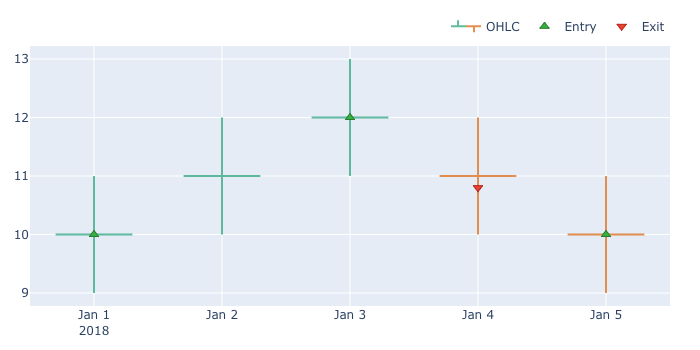

In [33]:
advstex = vbt.ADVSTEX.run(
    entries, price['open'], price['high'], price['low'], price['close'], 
    sl_stop=0.1
)

print(advstex.exits)
print(advstex.hit_price)
print(advstex.stop_type_readable)
advstex[(0.1, 'b')].plot().show_png()

In [34]:
advstex = vbt.ADVSTEX.run(
    entries, price['open'], price['high'], price['low'], price['close'], 
    sl_stop=[0.1, 0., 0.], ts_stop=[0., 0.1, 0.], tp_stop=[0., 0., 0.1]
)

print(advstex.exits)
print(advstex.hit_price)
print(advstex.stop_type_readable)

advstex_sl_stop    0.1                  0.0                                   
advstex_ts_stop    0.0                  0.1                  0.0              
advstex_tp_stop    0.0                  0.0                  0.1              
                     a      b      c      a      b      c      a      b      c
2018-01-01       False  False  False  False  False  False  False  False  False
2018-01-02       False  False  False  False  False  False   True   True  False
2018-01-03       False  False  False  False  False  False  False  False  False
2018-01-04       False   True   True   True   True   True  False  False  False
2018-01-05        True  False  False  False  False  False  False  False  False
advstex_sl_stop  0.1               0.0                            
advstex_ts_stop  0.0               0.1               0.0          
advstex_tp_stop  0.0               0.0               0.1          
                   a     b     c     a     b     c     a     b   c
2018-01-01       NaN 

In [35]:
%timeit vbt.ADVSTEX.run(\
    big_entries, big_ts, big_ts + 1, big_ts - 1, big_ts,\
    sl_stop=0.1, ts_stop=0.1, tp_stop=0.1)
%timeit vbt.ADVSTEX.run(\
    big_entries, big_ts, big_ts + 1, big_ts - 1, big_ts,\
    sl_stop=np.full(10, 0.1).tolist(), ts_stop=np.full(10, 0.1).tolist(), tp_stop=np.full(10, 0.1).tolist())

130 ms ± 3.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.32 s ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### IADVSTEX

iadvstex_sl_stop    0.1              
                      a      b      c
2018-01-01         True   True   True
2018-01-02        False  False  False
2018-01-03        False  False  False
2018-01-04        False  False  False
2018-01-05        False  False  False
iadvstex_sl_stop    0.1              
                      a      b      c
2018-01-01        False  False  False
2018-01-02        False  False  False
2018-01-03        False  False  False
2018-01-04        False  False  False
2018-01-05         True   True   True
iadvstex_sl_stop  0.1          
                    a    b    c
2018-01-01        NaN  NaN  NaN
2018-01-02        NaN  NaN  NaN
2018-01-03        NaN  NaN  NaN
2018-01-04        NaN  NaN  NaN
2018-01-05        9.0  9.0  9.0
iadvstex_sl_stop       0.1                    
                         a         b         c
2018-01-01                                    
2018-01-02                                    
2018-01-03                                    
2018-01-0

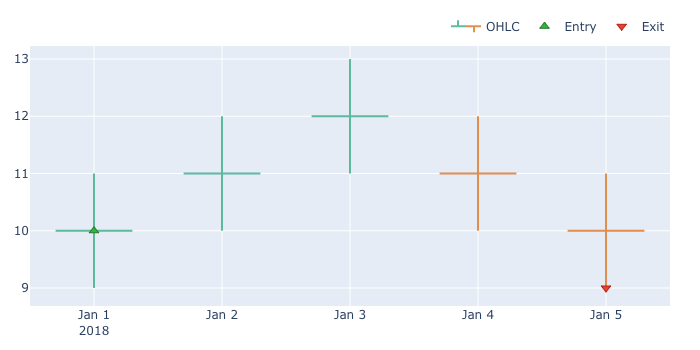

In [36]:
iadvstex = vbt.IADVSTEX.run(
    entries, price['open'], price['high'], price['low'], price['close'], 
    sl_stop=0.1
)

print(iadvstex.new_entries)
print(iadvstex.exits)
print(iadvstex.hit_price)
print(iadvstex.stop_type_readable)
iadvstex[(0.1, 'b')].plot().show_png()

In [37]:
%timeit vbt.IADVSTEX.run(\
    big_entries, big_ts, big_ts + 1, big_ts - 1, big_ts,\
    sl_stop=0.1, ts_stop=0.1, tp_stop=0.1)
%timeit vbt.IADVSTEX.run(\
    big_entries, big_ts, big_ts + 1, big_ts - 1, big_ts,\
    sl_stop=np.full(10, 0.1).tolist(), ts_stop=np.full(10, 0.1).tolist(), tp_stop=np.full(10, 0.1).tolist())

125 ms ± 3.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.1 s ± 49.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
